# Spatial Dataset Pre-Processing
Script that converts a pre-processed AnnData object from STARmap/SPARTseq to compatible Zarr format. 

In [1]:
# load packages
import anndata as ad 
import scanpy as sc
import numpy as np
import pandas as pd 
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt 
import seaborn as sns 
#import harmonypy as hm
import warnings
import os
import copy

from vitessce import (
    VitessceConfig,
    Component as cm,
    CoordinationType as ct,
    AnnDataWrapper,
)
from vitessce.data_utils import (
    optimize_adata,
    VAR_CHUNK_SIZE,
)

warnings.simplefilter(action="ignore", category=Warning)

sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

print("All packages loaded successfully!")

All packages loaded successfully!


In [2]:
# change the directory to general to access data 
path = "/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/"
os.chdir(path)

# verify the change
print("New working directory:", os.getcwd())

New working directory: /Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris


In [3]:
sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

scanpy==1.10.3 anndata==0.10.3 umap==0.5.7 numpy==1.24.4 scipy==1.9.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 pynndescent==0.5.13


### Load processed STARmap dataset

In [4]:
data = ad.read_h5ad("vitessce-cerebellum/data/e11_cell_types_4-13-25.h5ad")

In [5]:
# see dimensions of dataset
data 

AnnData object with n_obs × n_vars = 25341 × 1742
    obs: 'cell_number', 'library_id', 'timepoint', 'batch', 'n_genes_by_counts', 'total_counts', 'n_counts', 'leiden', 'cell_types', 'finer_cell_types'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_types_colors', 'finer_cell_types_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial', 'spatial3d'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

[<Axes: title={'center': 'Rora'}, xlabel='spatial1', ylabel='spatial2'>]

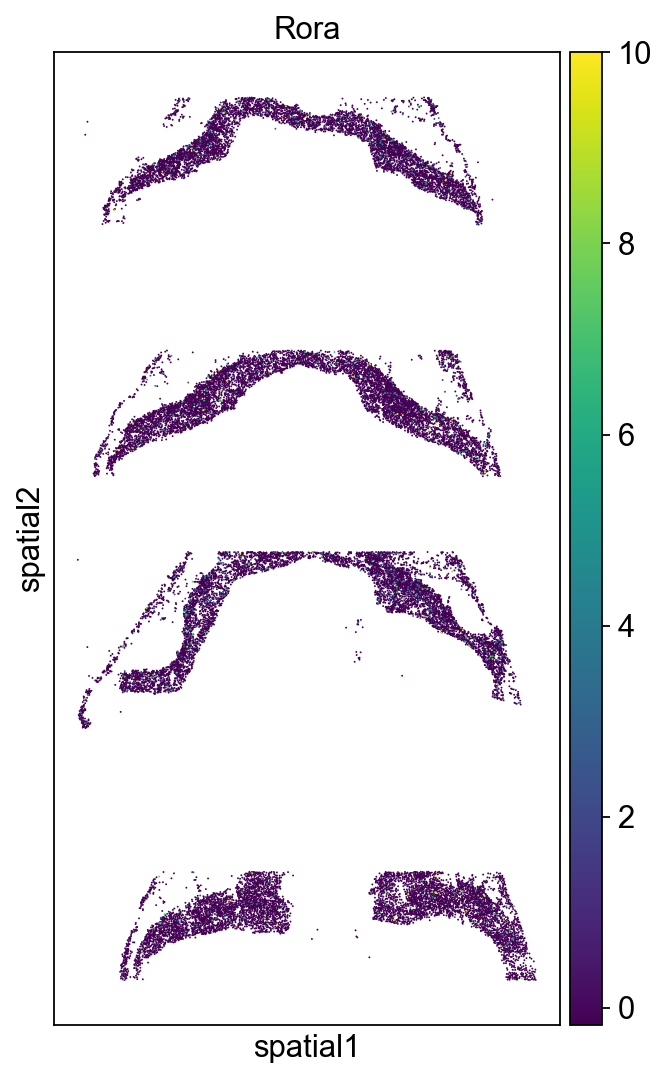

In [6]:
# visualize dataset spatially 
sc.pl.spatial(data, spot_size=75, color="Rora", show=False) 

Check summary of the AnnData fields:

In [7]:
data.obs.keys()

Index(['cell_number', 'library_id', 'timepoint', 'batch', 'n_genes_by_counts',
       'total_counts', 'n_counts', 'leiden', 'cell_types', 'finer_cell_types'],
      dtype='object')

In [8]:
data.obsm.keys()

KeysView(AxisArrays with keys: X_pca, X_pca_harmony, X_umap, spatial, spatial3d)

In [9]:
data.var.keys()

Index(['n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts',
       'total_counts', 'n_cells', 'mean', 'std'],
      dtype='object')

In [10]:
data.obs.rename(columns={'library_id': 'Coronal Slice ID'}, inplace=True) # 1-4 represents A-P 

In [12]:
# get the top 500 highlgy variable genes 
sc.pp.highly_variable_genes(data, flavor='seurat',n_top_genes=500)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [13]:
# get the highly variable gene matrix as a plain numpy array 
X_hvg_arr = data[:, data.var['highly_variable']].X.toarray()
X_hvg_index = data[:, data.var['highly_variable']].var.copy().index

In [14]:
import scipy
# Perform average linkage hierarchical clustering on along the genes axis of the array
Z = scipy.cluster.hierarchy.linkage(X_hvg_arr.T, method="average", optimal_ordering=True)

# Get the hierarchy-based ordering of genes.
num_genes = data.var.shape[0]
highly_var_index_ordering = scipy.cluster.hierarchy.leaves_list(Z)
highly_var_genes = X_hvg_index.values[highly_var_index_ordering].tolist()

all_genes = data.var.index.values.tolist()
not_var_genes = data.var.loc[~data.var['highly_variable']].index.values.tolist()

def get_orig_index(gene_id):
    return all_genes.index(gene_id)
var_index_ordering = list(map(get_orig_index, highly_var_genes)) + list(map(get_orig_index, not_var_genes))

At this point, we have obtained the optimal ordering of the genes index. 

In [15]:
# append the smaller 500-gene cell-by-gene matrix under a new key X_hvg w/ optimal gene ordering 
data.obsm['X_hvg'] = data[:, data.var['highly_variable']].X.copy()

In [16]:
data.obsm['spatial'] = data.obsm['spatial'].astype('uint16') # ensure that the spatial coordinates have a JavaScript-compatible integer data type

Normalize data.obsm['spatial'] to visualize in Vitessce. 

In [17]:
pd.DataFrame(data.obsm["spatial"], columns=["x", "y"]).describe()

,x,y
count,25341.000000,25341.000000
mean,9436.871315,16982.618010
std,4795.666965,10830.873116
min,0.000000,0.000000
25%,5001.000000,10521.000000
50%,9859.000000,18203.000000
75%,13657.000000,23454.000000
max,18185.000000,35048.000000


In [21]:
x_min = data.obsm["spatial"][:, 0].min()
y_min = data.obsm["spatial"][:, 1].min()

x_max = data.obsm["spatial"][:, 0].max()
y_max = data.obsm["spatial"][:, 1].max()

In [25]:
print(f"Based on above, our spatial coordinates currently range from:\nX: {x_min} -> {x_max} \nY: {y_min} -> {y_max}\nThese are very large and may cause Vitessce to render cells to very small, misaligned, or zoomed out. ")

Based on above, our spatial coordinates currently range from:
X: 0 -> 18185 
Y: 0 -> 35048
These are very large and may cause Vitessce to render cells to very small, misaligned, or zoomed out. 


In [27]:
# Extract spatial matrix 
spatial = data.obsm['spatial']

# Min-max normalization to [0,1]
spatial_min = spatial.min(axis=0)
spatial_max = spatial.max(axis=0)

data.obsm['spatial'] = (spatial - spatial_min) / (spatial_max - spatial_min)

# Scale to [0, 1000]
data.obsm['spatial'] *= 1000

# Verify the min-max normalization
print("Spatial coordinates after min-max normalization:")
print(data.obsm['spatial'].min(axis=0), data.obsm['spatial'].max(axis=0))

Spatial coordinates after min-max normalization:
[0. 0.] [1000. 1000.]


In [28]:
pd.DataFrame(data.obsm["spatial"], columns=["x", "y"]).describe()

,x,y
count,25341.000000,25341.000000
mean,518.937108,484.553127
std,263.715533,309.029705
min,0.000000,0.000000
25%,275.006874,300.188313
50%,542.150124,519.373431
75%,751.003574,669.196530
max,1000.000000,1000.000000


In [29]:
# Transpose the image to be compatible with the JavaScript-based image viewer in Vitessce. 
data.obsm["spatial"][:, 1] = 1000 - data.obsm["spatial"][:, 1]

Save processed data to a Zarr format. 

In [30]:
# change the directory to general to access data 
path = "/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/vitessce_tutorial/vitessce-cerebellum-gh-pages"
os.chdir(path)

# verify the change
print("New working directory:", os.getcwd())

New working directory: /Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/vitessce_tutorial/vitessce-cerebellum-gh-pages


In [31]:
# save processed data as a Zarr store using the AnnData write_zarr method
data.write_zarr("data/E11_Normalized.zarr")